## Import dependencies

In [44]:
import collections
from itertools import chain, combinations, islice, product
from operator import attrgetter
from random import shuffle

# Used only for data analysis, not simulation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Used to parallelize the simulation (achieves faster run times)
from joblib import Parallel, delayed
import multiprocessing

%matplotlib inline

## Methods

In [45]:
def create_named_tuples():
    Card = collections.namedtuple('Card', ['rank', 'suit'])
    PlayerInfo = collections.namedtuple('PlayerInfo', ['player', 'hole_cards', 'hole_cards_name'])
    HandValues = collections.namedtuple('HandValue', ['hand_name', 'hand_value', 'hand_kickers',
                                                       'hand_high', 'hand_low', 'hand_cards'])
    PlayerResults = collections.namedtuple('PlayerResult', ['game_num', 'num_players', 'player',
                                                            'hole_cards', 'best_hand', 'result'])
    return (Card, PlayerInfo, HandValues, PlayerResults)
    

def create_deck(card_tuple):
    '''Method to create a standard 52-card deck (not shuffled).
    Returns a deque of namedtuples.'''
    
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    suits = 'spades diamonds clubs hearts'.split()
    return collections.deque([card_tuple(rank, suit) for suit in suits
                                                     for rank in ranks])


def shuffle_deck(deck):
    '''Method to randomly shuffle the cards in a deck.
    Returns a deque of namedtuples.'''
    
    shuffle(deck)
    return deck


def deal_player_hands(deck, playerinfo_tuple, game='texas', players=5):
    '''Deals out hole cards to each player.  By default,
    2 and 4 hole cards are dealt for texas and omaha, respectively, to 5 players.
    This method also gives a colloquial name to each pair
    of hole cards, for later use in data analysis.
    A list containing a list of namedtuples of hole cards and
    the remaining cards in the deck is returned.
    '''
    if game == 'texas':
        hole_cards = 2
    elif game == 'omaha':
        hole_cards = 4
    else:
        raise ValueError('`game` must be either "Texas" or "Omaha".')
    
    player_hands = collections.defaultdict(list)
    for card in range(hole_cards):
        for player in range(1, players + 1):
            player_hands[player].append(deck.popleft())
                
    # get colloquial name for hole cards
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    if game == 'texas':
        for player in player_hands.keys():
            if player_hands[player][0].rank == player_hands[player][1].rank:
                player_hands[player].append('pair')
            elif ((player_hands[player][0].suit == player_hands[player][1].suit) and
                 (abs(ranks.index(player_hands[player][0].rank) - ranks.index(player_hands[player][1].rank)) == 1) or
                 (abs(ranks.index(player_hands[player][0].rank) - ranks.index(player_hands[player][1].rank)) == 12)):
                player_hands[player].append('suited connectors')
            elif player_hands[player][0].suit == player_hands[player][1].suit:
                player_hands[player].append('suited')
            elif ((abs(ranks.index(player_hands[player][0].rank) - ranks.index(player_hands[player][1].rank)) == 1) or
                  (abs(ranks.index(player_hands[player][0].rank) - ranks.index(player_hands[player][1].rank)) == 12)):
                player_hands[player].append('connectors')
            else:
                high_value = max(ranks.index(player_hands[player][0].rank), ranks.index(player_hands[player][1].rank))
                player_hands[player].append(ranks[high_value] + '-high')
    else:
        for player in player_hands.keys():
            player_hands[player].append('unknown')
            
    player_info = [playerinfo_tuple(player, player_hands[player][0:-1], player_hands[player][-1]) for player in player_hands.keys()]
    return [player_info, deck]


def deal_communal_cards(deck):
    '''Deals out the 5 communal cards.
    Returns a list of namedtuples.'''
    
    first_three = list(islice(deck, 1, 4))
    first_three.append(deck[5])
    first_three.append(deck[7])
    return first_three


def score_hand(hand, hand_values_tuple):
    '''Assigns a numeric value to poker hands, higher being better.
    `hand` should be a list of five cards.
    Returns a namedtuple.''' 
    
    def is_flush(suit_dict):
        return len(suit_dict) == 1
    
    def is_straight(numeral_dict):
        if len(numeral_dict) != 5:
            return False
        else:
            ranks = [str(n) for n in range(2, 11)] + list('JQKA')
            min_numeral = min([ranks.index(x) for x in numeral_dict.keys()])
            max_numeral = max([ranks.index(x) for x in numeral_dict.keys()])
            if int(max_numeral) - int(min_numeral) == 4:
                return True
            low_straight = set(("A", "2", "3", "4", "5"))
            if not set(numeral_dict.keys()).difference(low_straight):
                return True
    
    def is_straight_flush(numeral_dict, suit_dict):
        return is_straight(numeral_dict) and is_flush(suit_dict)
    
    def is_royal_flush(numeral_dict, suit_dict):
        return is_straight_flush(suit_dict, numeral_dict) and 'A' in numeral_dict.keys() and '10' in numeral_dict.keys()
    
    def is_four_of_a_kind(numeral_dict):
        return 4 in numeral_dict.values()
    
    def is_three_of_a_kind(numeral_dict):
        return 3 in numeral_dict.values()
    
    def is_full_house(numeral_dict):
        return len(numeral_dict) == 2 and 3 in numeral_dict.values() and 2 in numeral_dict.values()
    
    def is_two_pair(numeral_dict):
        return len(numeral_dict) == 3 and 2 in numeral_dict.values() and 1 in numeral_dict.values()
    
    def is_pair(numeral_dict):
        return 2 in numeral_dict.values()
        
    numeral_dict = collections.defaultdict(int)
    suit_dict = collections.defaultdict(int)
    for card in hand:
        numeral_dict[card.rank] += 1
        suit_dict[card.suit] += 1
    
    ranks = [str(n) for n in range(2, 11)] + list('JQKA')
    highest_rank = ranks[max([ranks.index(rank) for rank in numeral_dict.keys()])]
    lowest_rank = ranks[min([ranks.index(rank) for rank in numeral_dict.keys()])]
    
    if is_royal_flush(numeral_dict, suit_dict):
        return hand_values_tuple('royal flush', 10, None, highest_rank, lowest_rank, hand)
    elif is_straight_flush(numeral_dict, suit_dict):
        return hand_values_tuple('straight flush', 9, None, highest_rank, lowest_rank, hand)
    elif is_four_of_a_kind(numeral_dict):
        # `High` for four-of-a-kind corresponds to the set of 4
        kicker = [rank for rank in numeral_dict.keys() if numeral_dict[rank] == 1]
        high = [rank for rank in numeral_dict.keys() if numeral_dict[rank] == 4]
        return hand_values_tuple('4-of-a-kind', 8, kicker, high[0], lowest_rank, hand)
    elif is_full_house(numeral_dict):
        # `High` for a full house corresponds to the set of 3
        high = [rank for rank in numeral_dict.keys() if numeral_dict[rank] == 3]
        low = [rank for rank in numeral_dict.keys() if numeral_dict[rank] == 2]
        return hand_values_tuple('full house', 7, None, high[0], low[0], hand)
    elif is_flush(suit_dict):
        # 'kickers' are all cards, sorted from highest to lowest value
        kicker_indices = sorted([ranks.index(rank) for rank in numeral_dict.keys()], reverse=True)
        return hand_values_tuple('flush', 6, [ranks[index] for index in kicker_indices], highest_rank, lowest_rank, hand)
    elif is_straight(numeral_dict):
        return hand_values_tuple('straight', 5, None, highest_rank, lowest_rank, hand)
    elif is_three_of_a_kind(numeral_dict):
        # `High` for three-of-a-kind corresponds to the set of 3
        high = [rank for rank in numeral_dict.keys() if numeral_dict[rank] == 3]
        kicker_indices = sorted([ranks.index(rank) for rank in numeral_dict.keys() if numeral_dict[rank] != 3], reverse=True)
        return hand_values_tuple('3-of-a-kind', 4, [ranks[index] for index in kicker_indices], high[0], lowest_rank, hand)
    elif is_two_pair(numeral_dict):
        # `High` for two pair is the rank of the highest pair
        # `Low` for two pair is the rank of the lowest pair
        pair_indices = [ranks.index(rank) for rank in numeral_dict.keys() if numeral_dict[rank] == 2]
        kicker = [rank for rank in numeral_dict.keys() if numeral_dict[rank] == 1]
        return hand_values_tuple('2-pair', 3, kicker, ranks[max(pair_indices)], ranks[min(pair_indices)], hand)
    elif is_pair(numeral_dict):
        # `High` for a pair is the rank of the pair
        kicker_indices = sorted([ranks.index(rank) for rank in numeral_dict.keys() if numeral_dict[rank] != 2], reverse=True)
        pair_index = [ranks.index(rank) for rank in numeral_dict.keys() if numeral_dict[rank] == 2][0]
        return hand_values_tuple('pair', 2, [ranks[index] for index in kicker_indices], ranks[pair_index], lowest_rank, hand)
    else:
        # 'kickers' are all cards, sorted from highest to lowest value
        kicker_indices = sorted([ranks.index(rank) for rank in numeral_dict.keys()], reverse=True)
        return hand_values_tuple('high card', 1, [ranks[index] for index in kicker_indices], highest_rank, lowest_rank, hand) 

    
def find_top_hand_for_player(hands, hand_values_tuple):
    '''Takes in a list of hands and ranks them from best to worst'''
    hand_scores = [score_hand(hand, hand_values_tuple) for hand in hands]
    bad_scores = [x for x in hand_scores if not(x.hand_value > 0)]
    if len(bad_scores) > 0:
        print(bad_scores)
        raise Error('Uh oh...There was a bad score...')
    sorted_hands = sorted(hand_scores, key=attrgetter('hand_value'), reverse=True)
    top_hands = [hand for hand in sorted_hands if hand.hand_value == sorted_hands[0].hand_value]
    # No extra work needed if only 1 top hand is present.
    # (Or if there are multiple royal flush or 4-of-a-kind top hands, which actually can't happen.)
    if ((len(top_hands) == 1) or (top_hands[0].hand_name == 'royal flush')
        or (top_hands[0].hand_name == '4-of-a-kind')):
        return top_hands[0]
    else:
        ranks = [str(n) for n in range(2, 11)] + list('JQKA')
        hand_type = top_hands[0].hand_name
        if 'straight' in hand_type:
            high_card_indices = sorted([ranks.index(hand.hand_high) for hand in top_hands], reverse=True)
            return [hand for hand in top_hands if hand.hand_high == ranks[high_card_indices[0]]][0]
        elif (hand_type == 'flush') or (hand_type == 'high card'):
            best_hand = top_hands[0]
            for hand in top_hands[1:]:
                # Convert kickers (already sorted high to low) to integers and concatenate into one large number
                new_int = int("".join([str(ranks.index(kicker)) for kicker in hand.hand_kickers]))
                best_int = int("".join([str(ranks.index(kicker)) for kicker in best_hand.hand_kickers]))
                if new_int > best_int:
                    best_hand = hand
                else:
                    pass
        elif hand_type == 'full house': 
            best_hand = top_hands[0]
            for hand in top_hands[1:]:
                # Check trips
                if ranks.index(hand.hand_high) > ranks.index(best_hand.hand_high):
                    best_hand = hand
                elif ranks.index(hand.hand_high) == ranks.index(best_hand.hand_high):
                    if ranks.index(hand.hand_low) > ranks.index(best_hand.hand_low):
                        best_hand = hand
                    else:
                        pass
                else:
                    pass
        elif hand_type == '3-of-a-kind':
            best_hand = top_hands[0]
            for hand in top_hands[1:]:
                if ranks.index(hand.hand_high) > ranks.index(best_hand.hand_high):
                    best_hand = hand
                elif ranks.index(hand.hand_high) == ranks.index(best_hand.hand_high):
                    # Convert kickers (already sorted high to low) to integers and concatenate into one large number
                    new_int = int("".join([str(ranks.index(kicker)) for kicker in hand.hand_kickers]))
                    best_int = int("".join([str(ranks.index(kicker)) for kicker in best_hand.hand_kickers]))
                    if new_int > best_int:
                        best_hand = hand
                    else:
                        pass
                else:
                    pass
        elif hand_type == '2-pair':
            best_hand = top_hands[0]
            for hand in top_hands[1:]:
                if ranks.index(hand.hand_high) > ranks.index(best_hand.hand_high):
                    best_hand = hand
                elif ranks.index(hand.hand_high) == ranks.index(best_hand.hand_high):
                    if ranks.index(hand.hand_low) > ranks.index(best_hand.hand_low):
                        best_hand = hand
                    elif ranks.index(hand.hand_low) == ranks.index(best_hand.hand_low):
                        if ranks.index(hand.hand_kickers[0]) > ranks.index(best_hand.hand_kickers[0]):
                            best_hand = hand
                        else: pass
                    else:
                        pass
                else:
                    pass
        else: # pairs
            best_hand = top_hands[0]
            for hand in top_hands[1:]:
                if ranks.index(hand.hand_high) > ranks.index(best_hand.hand_high):
                    best_hand = hand
                elif ranks.index(hand.hand_high) == ranks.index(best_hand.hand_high):
                    # Convert kickers (already sorted high to low) to integers and concatenate into one large number
                    new_int = int("".join([str(ranks.index(kicker)) for kicker in hand.hand_kickers]))
                    best_int = int("".join([str(ranks.index(kicker)) for kicker in best_hand.hand_kickers]))
                    if new_int > best_int:
                        best_hand = hand
                    else:
                        pass
                else:
                    pass
        return best_hand

    
def find_winners(hands):
    '''Method to rank the top hand of each player, accounting for ties'''
    winning_value = max([x.hand_value for x in hands])
    # If there is only one hand at the top, then return that as the winner
    winners = [x for x in hands if x.hand_value == winning_value]
    if (len(winners) == 1) or (winners[0].hand_name == 'royal flush'):
        return winners
    else:
        ranks = [str(n) for n in range(2, 11)] + list('JQKA')
        high_rank = ranks[max([ranks.index(x.hand_high) for x in winners])]
        
        if 'straight' in winners[0].hand_name:
            return [x for x in winners if x.hand_high == high_rank]    
        elif winners[0].hand_name == '4-of-a-kind':
            high_kicker = ranks[max([ranks.index(x.hand_kickers[0]) for x in winners])]
            return [x for x in winners if (x.hand_high == high_rank) and (x.hand_kickers[0] == high_kicker)]   
        elif winners[0].hand_name == 'full house':
            new_winners = [x for x in winners if x.hand_high == high_rank]
            if len(new_winners) == 1:
                return new_winners
            else:
                best_low = ranks[max([ranks.index(x.hand_low) for x in new_winners])]
                return [x for x in new_winners if x.hand_low == best_low]     
        elif ((winners[0].hand_name == 'flush') or (winners[0].hand_name == '3-of-a-kind') or
              (winners[0].hand_name == 'high card') or (winners[0].hand_name == 'pair')):
            new_winners = [x for x in winners if x.hand_high == high_rank]
            if len(new_winners) == 1:
                return new_winners
            else:
                totals = {}
                for i,hand in enumerate(new_winners):
                    # Convert kickers (already sorted high to low) to integers and concatenate into one large number
                    totals[i] = int("".join([str(ranks.index(kicker)) for kicker in hand.hand_kickers]))
                best_total = max(totals.values())
                return [x for i,x in enumerate(new_winners) if totals[i] == best_total]   
        else: #2-pairs
            new_winners = [x for x in winners if x.hand_high == high_rank]
            if len(new_winners) == 1:
                return new_winners
            else:
                best_low = ranks[max([ranks.index(x.hand_low) for x in new_winners])]
                best_kicker = ranks[max([ranks.index(x.hand_kickers[0]) for x in new_winners])]
                return [x for x in new_winners if (x.hand_low == best_low) and (x.hand_kickers[0] == best_kicker)]

## Simulate single game

In [9]:
%%time
from pdb import set_trace as bp
game = 'omaha'
games = 1
players = 2

# Create named tuples
named_tuples = create_named_tuples()

# Create original, shuffled deck of 52 cards
deck = shuffle_deck(create_deck(named_tuples[0]))

# Deal each player a hand
player_hands = deal_player_hands(deck, named_tuples[1], game=game, players=players)

# Deal communal cards
communal_cards = deal_communal_cards(player_hands[1])

top_hands = {}
for player in range(players):
    if game == 'texas':
        hands_list = combinations(player_hands[0][player].hole_cards + communal_cards, 5)
    else:
        hands_list = [list(chain(item[0], item[1])) for item in product(
            combinations(player_hands[0][player].hole_cards, 2),
            combinations(communal_cards, 3))]
    top_hands[player + 1] = find_top_hand_for_player(hands_list, named_tuples[2])

winning_hands = find_winners(top_hands.values())    

game_results = []
for player in top_hands.keys():
    if top_hands[player] in winning_hands:
        if len(winning_hands) == 1:
            winloss = 'Win'
        else:
            winloss = 'Draw'
    else:
        winloss = 'Loss'
        
    game_results.append(named_tuples[3](
        games,
        players,
        player,
        player_hands[0][player - 1].hole_cards_name,
        top_hands[player].hand_name,
        winloss))


Wall time: 5.98 ms


In [10]:
game_results

[PlayerResult(game_num=1, num_players=2, player=1, hole_cards='unknown', best_hand='2-pair', result='Loss'),
 PlayerResult(game_num=1, num_players=2, player=2, hole_cards='unknown', best_hand='3-of-a-kind', result='Win')]

## Simulate Multiple Games with Various Players

In [26]:
%%time
game = 'omaha'
games = 10
max_players = 10
game_results = []

# Create named tuples
named_tuples = create_named_tuples()

for players in range(2, max_players + 1):
    for game_num in range(games):
        # Create original, shuffled deck of 52 cards
        deck = shuffle_deck(create_deck(named_tuples[0]))

        # Deal each player a hand
        player_hands = deal_player_hands(deck, named_tuples[1], game=game, players=players)

        # Deal communal cards
        communal_cards = deal_communal_cards(player_hands[1])

        top_hands = {}
        for player in range(players):
            if game == 'texas':
                hands_list = combinations(player_hands[0][player].hole_cards + communal_cards, 5)
            else:
                hands_list = [list(chain(item[0], item[1])) for item in product(
                    combinations(player_hands[0][player].hole_cards, 2),
                    combinations(communal_cards, 3))]
            top_hands[player + 1] = find_top_hand_for_player(hands_list, named_tuples[2])

            winning_hands = find_winners(top_hands.values())    
        
        for player in top_hands.keys():
            if top_hands[player] in winning_hands:
                if len(winning_hands) == 1:
                    winloss = 'Win'
                else:
                    winloss = 'Draw'
            else:
                winloss = 'Loss'

            game_results.append(named_tuples[3](
                game_num + 1,
                players,
                player,
                player_hands[0][player - 1].hole_cards_name,
                top_hands[player].hand_name,
                winloss))
        

Wall time: 1.19 s


In [27]:
game_results

[PlayerResult(game_num=1, num_players=2, player=1, hole_cards='unknown', best_hand='2-pair', result='Loss'),
 PlayerResult(game_num=1, num_players=2, player=2, hole_cards='unknown', best_hand='2-pair', result='Win'),
 PlayerResult(game_num=2, num_players=2, player=1, hole_cards='unknown', best_hand='2-pair', result='Win'),
 PlayerResult(game_num=2, num_players=2, player=2, hole_cards='unknown', best_hand='pair', result='Loss'),
 PlayerResult(game_num=3, num_players=2, player=1, hole_cards='unknown', best_hand='pair', result='Win'),
 PlayerResult(game_num=3, num_players=2, player=2, hole_cards='unknown', best_hand='high card', result='Loss'),
 PlayerResult(game_num=4, num_players=2, player=1, hole_cards='unknown', best_hand='2-pair', result='Loss'),
 PlayerResult(game_num=4, num_players=2, player=2, hole_cards='unknown', best_hand='straight', result='Win'),
 PlayerResult(game_num=5, num_players=2, player=1, hole_cards='unknown', best_hand='2-pair', result='Loss'),
 PlayerResult(game_num

## Master Functions

In [46]:
def simulator_linear(num_games, named_tuples, game='texas', min_players=2, max_players=10):
    game_results = []
    for players in range(min_players, max_players + 1):
        for game_num in range(num_games):
            # Create original, shuffled deck of 52 cards
            deck = shuffle_deck(create_deck(named_tuples[0]))

            # Deal each player a hand
            player_hands = deal_player_hands(deck, named_tuples[1], game=game, players=players)

            # Deal communal cards
            communal_cards = deal_communal_cards(player_hands[1])

            top_hands = {}
            for player in range(players):
                if game == 'texas':
                    hands_list = combinations(player_hands[0][player].hole_cards + communal_cards, 5)
                else:
                    hands_list = [list(chain(item[0], item[1])) for item in product(
                        combinations(player_hands[0][player].hole_cards, 2),
                        combinations(communal_cards, 3))]
                top_hands[player + 1] = find_top_hand_for_player(hands_list, named_tuples[2])

                winning_hands = find_winners(top_hands.values())     

            for player in top_hands.keys():
                if top_hands[player] in winning_hands:
                    if len(winning_hands) == 1:
                        winloss = 'Win'
                    else:
                        winloss = 'Draw'
                else:
                    winloss = 'Loss'

                game_results.append(named_tuples[3](
                    game_num,
                    players,
                    player,
                    player_hands[0][player - 1].hole_cards_name,
                    top_hands[player].hand_name,
                    winloss))
    return game_results

def simulator_parallel(players, named_tuples, game='texas', num_games=1000):
    # Runs 10,000 games for `players`
    game_results = []
    for game_num in range(num_games):
        # Create original, shuffled deck of 52 cards
        deck = shuffle_deck(create_deck(named_tuples[0]))

        # Deal each player a hand
        player_hands = deal_player_hands(deck, named_tuples[1], game=game, players=players)

        # Deal communal cards
        communal_cards = deal_communal_cards(player_hands[1])

        top_hands = {}
        for player in range(players):
            if game == 'texas':
                hands_list = combinations(player_hands[0][player].hole_cards + communal_cards, 5)
            else:
                hands_list = [list(chain(item[0], item[1])) for item in product(
                    combinations(player_hands[0][player].hole_cards, 2),
                    combinations(communal_cards, 3))]
            top_hands[player + 1] = find_top_hand_for_player(hands_list, named_tuples[2])

            winning_hands = find_winners(top_hands.values())        

        for player in top_hands.keys():
            if top_hands[player] in winning_hands:
                if len(winning_hands) == 1:
                    winloss = 'Win'
                else:
                    winloss = 'Draw'
            else:
                winloss = 'Loss'

            game_results.append(player_results(
                game_num,
                players,
                player,
                player_hands[0][player - 1].hole_cards_name,
                top_hands[player].hand_name,
                winloss))
    return game_results

## Analysis of 100,000 Games for Each of 2-10 Players

In [33]:
'''%%time
texas_results_linear = simulator_linear(
    num_games=1_000,
    named_tuples=create_named_tuples(),
    game='texas',
    min_players=2,
    max_players=10)'''

Wall time: 44 s


In [47]:
# what are your inputs, and what operation do you want to 
# perform on each input. For example...
players = range(2, 11)
num_cores = multiprocessing.cpu_count()

In [66]:
%%time
# Simulate 1,000 games of Texas Holdem' for each of 2-10 players
named_tuples = create_named_tuples()
texas_results_parallel = list(chain.from_iterable(
    Parallel(n_jobs=num_cores)(
        delayed(simulator_parallel)
        (players=i, named_tuples=named_tuples, game='texas', num_games=100_000) for i in players)))

Wall time: 35min 56s


In [68]:
1742/pd.DataFrame(texas_results_parallel).best_hand.value_counts().sum()*100

0.03225925925925926

In [49]:
%%time
# Simulate 1,000 games of Omaha for each of 2-10 players
named_tuples = create_named_tuples()
omaha_results_parallel = list(chain.from_iterable(
    Parallel(n_jobs=num_cores)(
        delayed(simulator_parallel)
        (players=i, named_tgame='omaha', num_games=1_000) for i in players)))

Wall time: 1min 10s


In [50]:
pd.DataFrame(omaha_results_parallel).best_hand.value_counts()

2-pair            19806
pair              14555
straight           6069
3-of-a-kind        4662
flush              3563
full house         3425
high card          1626
4-of-a-kind         252
straight flush       42
Name: best_hand, dtype: int64

In [69]:
def create_results_df(results, texas=True):
    results_df = pd.DataFrame(results)
    results_df2 = pd.concat([results_df, pd.get_dummies(results_df['result'])], axis=1)
    results_df2['best_hand'] = pd.Categorical(
        results_df2['best_hand'],
        ['royal flush', 'straight flush', '4-of-a-kind', 'full house', 'flush', 'straight',
         '3-of-a-kind', '2-pair', 'pair', 'high card'])
    if texas:
        results_df2['hole_cards'] = pd.Categorical(
            results_df2['hole_cards'],
            ['pair', 'suited connectors', 'suited', 'connectors', 'A-high', 'K-high', 'Q-high', 'J-high',
             '10-high', '9-high', '8-high', '7-high', '6-high', '5-high', '4-high'])
    return results_df2
        

texas_results_df = create_results_df(texas_results_parallel, texas=True)
#omaha_results_df = create_results_df(omaha_results_parallel, texas=False)

texas_results_df.head()
#omaha_results_df.head()

,game_num,num_players,player,hole_cards,best_hand,result,Draw,Loss,Win
0,0,2,1,A-high,pair,Loss,0,1,0
1,0,2,2,suited,pair,Win,0,0,1
2,1,2,1,connectors,high card,Loss,0,1,0
3,1,2,2,suited,pair,Win,0,0,1
4,2,2,1,pair,full house,Win,0,0,1


In [70]:
win_draw_by_hole_cards = texas_results_df.groupby(['num_players', 'hole_cards']).apply(lambda x: (np.sum(x.Win) + np.sum(x.Draw)) / (np.sum(x.Win) + np.sum(x.Draw) + np.sum(x.Loss)))
pd.DataFrame(win_draw_by_hole_cards).sort_values('hole_cards').reset_index().pivot('hole_cards', 'num_players', 0)

num_players,2,3,4,5,6,7,8,9,10
hole_cards,,,,,,,,,
pair,0.677193,0.502615,0.390196,0.319534,0.271505,0.232873,0.209303,0.187444,0.167917
suited connectors,0.532046,0.374479,0.294251,0.246246,0.213283,0.192381,0.168928,0.155211,0.144443
suited,0.524405,0.360189,0.278184,0.227456,0.196716,0.174007,0.156011,0.143816,0.132971
connectors,0.490602,0.339437,0.260714,0.214745,0.180032,0.158978,0.140506,0.127666,0.115509
A-high,0.619562,0.424551,0.329341,0.260284,0.219394,0.188076,0.167213,0.147105,0.132269
K-high,0.570325,0.376788,0.279000,0.224840,0.183754,0.160021,0.136620,0.122765,0.108875
Q-high,0.533309,0.341264,0.250076,0.201252,0.164804,0.140852,0.122319,0.108425,0.097651
J-high,0.495562,0.313994,0.234888,0.185187,0.153280,0.129422,0.112984,0.098038,0.089431
10-high,0.473123,0.290843,0.215867,0.168554,0.137348,0.118398,0.106073,0.093653,0.086390


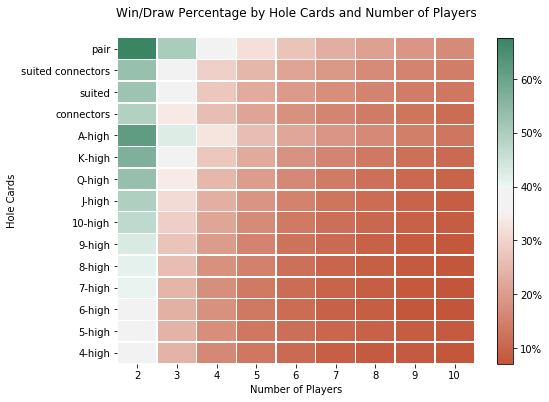

In [71]:
win_draw_by_hole_cards = texas_results_df.groupby(['num_players', 'hole_cards']).apply(lambda x: (np.sum(x.Win) + np.sum(x.Draw)) / (np.sum(x.Win) + np.sum(x.Draw) + np.sum(x.Loss)))

plt.figure(figsize=(8,6))
ax = sns.heatmap(pd.DataFrame(win_draw_by_hole_cards).sort_values('hole_cards').reset_index().pivot('hole_cards', 'num_players', 0),
            cmap=sns.diverging_palette(20, 150, sep=20, as_cmap=True),
            linewidths=.5,
            cbar=False)
ax.set(xlabel='Number of Players', ylabel='Hole Cards', title='Win/Draw Percentage by Hole Cards and Number of Players\n')
cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_ticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
cbar.set_ticklabels(["10%", "20%", "30%", "40%", "50%", "60%", "70%"])
ax.figure.savefig('heatmap_hole_cards.svg', bbox_inches="tight")

In [72]:
texas_win_draw_by_best_hand = texas_results_df.groupby(['num_players', 'best_hand']).apply(lambda x: (np.sum(x.Win) + np.sum(x.Draw)) / (np.sum(x.Win) + np.sum(x.Draw) + np.sum(x.Loss)))
pd.DataFrame(texas_win_draw_by_best_hand).sort_values('best_hand').reset_index().pivot('best_hand', 'num_players', 0)

num_players,2,3,4,5,6,7,8,9,10
best_hand,,,,,,,,,
straight flush,1.000000,1.000000,0.973684,0.993333,0.980583,0.975000,0.974249,0.915825,0.928571
4-of-a-kind,0.917379,0.897087,0.926635,0.911137,0.864943,0.886364,0.847592,0.906188,0.885943
full house,0.944444,0.891556,0.856588,0.806363,0.766279,0.738325,0.706957,0.681426,0.664700
flush,0.883008,0.791001,0.721614,0.651588,0.603003,0.559764,0.521866,0.494780,0.462479
straight,0.927473,0.874628,0.817979,0.772874,0.739812,0.702829,0.679461,0.647960,0.629816
3-of-a-kind,0.761866,0.657593,0.579855,0.534984,0.498693,0.459086,0.433494,0.405816,0.384244
2-pair,0.674374,0.482143,0.362083,0.274735,0.213525,0.171836,0.138708,0.116248,0.095753
pair,0.440674,0.236022,0.143934,0.093681,0.063900,0.046350,0.033680,0.025375,0.019507
high card,0.183543,0.041244,0.010325,0.002537,0.000566,0.000148,0.000043,0.000000,0.000000


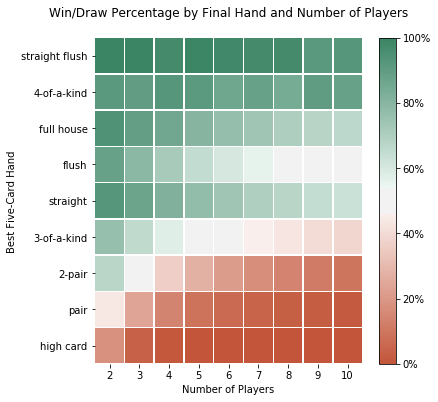

In [73]:
texas_win_draw_by_best_hand = texas_results_df.groupby(['num_players', 'best_hand']).apply(lambda x: (np.sum(x.Win) + np.sum(x.Draw)) / (np.sum(x.Win) + np.sum(x.Draw) + np.sum(x.Loss)))

plt.figure(figsize=(6,6))
ax = sns.heatmap(pd.DataFrame(texas_win_draw_by_best_hand).sort_values('best_hand').reset_index().pivot('best_hand', 'num_players', 0),
            cmap=sns.diverging_palette(20, 150, sep=20, as_cmap=True),
            linewidths=.5,
            cbar=False)
ax.set(xlabel='Number of Players', ylabel='Best Five-Card Hand', title='Win/Draw Percentage by Final Hand and Number of Players\n')
cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.figure.savefig('heatmap_final_hand.svg', bbox_inches="tight")

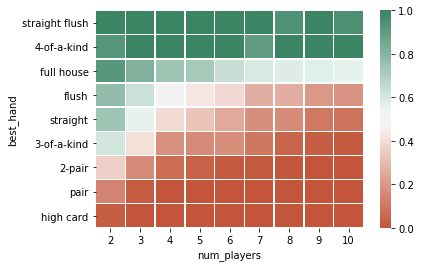

In [96]:
omaha_results_df2 = pd.concat([omaha_results_df, pd.get_dummies(omaha_results_df['result'])], axis=1)
omaha_win_draw_by_best_hand = omaha_results_df2.groupby(['num_players', 'best_hand']).apply(lambda x: (np.sum(x.Win) + np.sum(x.Draw)) / (np.sum(x.Win) + np.sum(x.Draw) + np.sum(x.Loss)))
sns.heatmap(pd.DataFrame(omaha_win_draw_by_best_hand).sort_values('best_hand').reset_index().pivot('best_hand', 'num_players', 0),
            cmap=sns.diverging_palette(20, 150, sep=20, as_cmap=True),
            linewidths=.5)

## Profiling
(It seems that most of the time is spent creating the `namedtuples`.  This explains why calculating the time/game for 1, 10, and 100 games all come out roughly equal (i.e., the time doesn't explode as you add more games or players).) 

In [5]:
%load_ext line_profiler

In [48]:
import time

In [33]:
# Get times to run based on number of games
results = []
for game in [1, 10, 100]:
    start_time = time.time()
    simulator(game, 2, 10)
    elapsed_time = time.time() - start_time
    results.append((game, elapsed_time, elapsed_time / game))
results

[(1, 0.24038934707641602, 0.24038934707641602),
 (10, 1.5767836570739746, 0.15767836570739746),
 (100, 19.3154399394989, 0.19315439939498902)]

In [37]:
# Profile a single game with 5 players
%lprun -f simulator simulator(1, 5, 5)

Timer unit: 1e-07 s

Total time: 0.0917105 s
File: <ipython-input-32-4d102e82a851>
Function: simulator at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def simulator(num_games, min_players=2, max_players=10):
     2         1         21.0     21.0      0.0      game_results = []
     3         2         37.0     18.5      0.0      for players in range(min_players, max_players + 1):
     4         2         23.0     11.5      0.0          for game in range(num_games):
     5                                                       # Create original, shuffled deck of 52 cards
     6         1       5439.0   5439.0      0.6              deck = shuffle_deck(create_deck())
     7                                           
     8                                                       # Deal each player a hand
     9         1       3929.0   3929.0      0.4              player_hands = deal_player_hands(deck, cards=2, player

In [44]:
# What takes longer: Combinations or actual method?
def all_hands(cards,choice=5):
    return combinations(cards, choice)
deck = shuffle_deck(create_deck())
player_hands = deal_player_hands(deck, cards=2, players=1)
communal_cards = deal_communal_cards(player_hands[1])
%timeit all_hands(player_hands[0][0].cards + communal_cards, 5)

644 ns ± 24.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [45]:
# Profile find_top_hand_for_player()
deck = shuffle_deck(create_deck())
player_hands = deal_player_hands(deck, cards=2, players=1)
communal_cards = deal_communal_cards(player_hands[1])
hands = combinations(player_hands[0][0].cards + communal_cards, 5)
%lprun -f find_top_hand_for_player find_top_hand_for_player(combinations(player_hands[0][0].cards + communal_cards, 5))

Timer unit: 1e-07 s

Total time: 0.0156545 s
File: <ipython-input-7-55711bc8dc22>
Function: find_top_hand_for_player at line 163

Line #      Hits         Time  Per Hit   % Time  Line Contents
   163                                           def find_top_hand_for_player(hands):
   164                                               '''Takes in a list of hands and ranks them from best to worst'''
   165         1     136794.0 136794.0     87.4      hand_scores = [score_hand(hand) for hand in hands]
   166         1        288.0    288.0      0.2      sorted_hands = sorted(hand_scores, key=attrgetter('value'), reverse=True)
   167         1        280.0    280.0      0.2      top_hands = [hand for hand in sorted_hands if hand.value == sorted_hands[0].value]
   168                                               # No extra work needed if only 1 top hand is present.
   169                                               # (Or if there are multiple royal flush or 4-of-a-kind top hands, which actu

In [47]:
%lprun -f score_hand score_hand(list(hands)[0])

Timer unit: 1e-07 s

Total time: 0.0007198 s
File: <ipython-input-7-55711bc8dc22>
Function: score_hand at line 67

Line #      Hits         Time  Per Hit   % Time  Line Contents
    67                                           def score_hand(hand):
    68                                               '''Assigns a numeric value to poker hands, higher being better.
    69                                               `hand` should be a list of five cards.
    70                                               Returns a namedtuple.''' 
    71                                               
    72         1         69.0     69.0      1.0      def is_flush(suit_dict):
    73                                                   return len(suit_dict) == 1
    74                                               
    75         1         56.0     56.0      0.8      def is_straight(numeral_dict):
    76                                                   if len(numeral_dict) != 5:
    77                   

## Profile score_hand() Method

In [17]:
# Royal Flush
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='A',suit='spades'),Card(rank='K',suit='spades'),Card(rank='Q',suit='spades'),
        Card(rank='J',suit='spades'),Card(rank='10',suit='spades')]
%timeit score_hand(hand)

105 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%lprun -f score_hand score_hand(hand)

Timer unit: 1e-07 s

Total time: 0.0008778 s
File: <ipython-input-3-768007a7e4e3>
Function: score_hand at line 77

Line #      Hits         Time  Per Hit   % Time  Line Contents
    77                                           def score_hand(hand):
    78                                               '''Assigns a numeric value to poker hands, higher being better.
    79                                               `hand` should be a list of five cards.
    80                                               Returns a namedtuple.''' 
    81                                               
    82         1         74.0     74.0      0.8      def is_flush(suit_dict):
    83                                                   return len(suit_dict) == 1
    84                                               
    85         1         56.0     56.0      0.6      def is_straight(numeral_dict):
    86                                                   if len(numeral_dict) != 5:
    87                   

In [8]:
# Straight Flush
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='K',suit='spades'),Card(rank='Q',suit='spades'),
        Card(rank='J',suit='spades'),Card(rank='10',suit='spades')]
%timeit score_hand(hand)

116 µs ± 5.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
# 4-of-a-kind
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='9',suit='hearts'),Card(rank='9',suit='clubs'),
        Card(rank='9',suit='diamonds'),Card(rank='10',suit='spades')]
%timeit score_hand(hand)

108 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
# full house
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='9',suit='hearts'),Card(rank='9',suit='clubs'),
        Card(rank='8',suit='diamonds'),Card(rank='8',suit='spades')]
%timeit score_hand(hand)

106 µs ± 7.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
# flush
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='2',suit='spades'),Card(rank='4',suit='spades'),
        Card(rank='7',suit='spades'),Card(rank='8',suit='spades')]
%timeit score_hand(hand)

128 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
# straight
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='6',suit='hearts'),Card(rank='10',suit='spades'),
        Card(rank='7',suit='spades'),Card(rank='8',suit='spades')]
%timeit score_hand(hand)

131 µs ± 6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
# 3-of-a-kind
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='9',suit='hearts'),Card(rank='9',suit='diamonds'),
        Card(rank='7',suit='spades'),Card(rank='8',suit='spades')]
%timeit score_hand(hand)

113 µs ± 4.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
# 2-pair
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='9',suit='hearts'),Card(rank='8',suit='diamonds'),
        Card(rank='7',suit='spades'),Card(rank='8',suit='spades')]
%timeit score_hand(hand)

111 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
# pair
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='9',suit='spades'),Card(rank='9',suit='hearts'),Card(rank='8',suit='diamonds'),
        Card(rank='7',suit='spades'),Card(rank='6',suit='spades')]
%timeit score_hand(hand)

116 µs ± 7.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
# high card
Card = collections.namedtuple('Card', ['rank', 'suit'])
hand = [Card(rank='A',suit='spades'),Card(rank='9',suit='hearts'),Card(rank='8',suit='diamonds'),
        Card(rank='7',suit='spades'),Card(rank='6',suit='spades')]
%timeit score_hand(hand)

131 µs ± 6.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%timeit hand_values = collections.namedtuple('HandValue', ['name', 'value', 'kickers', 'high', 'low'])

62.6 µs ± 993 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
